In [32]:
import subprocess, sys
packages = ['xgboost', 'imbalanced-learn', 'scikit-learn', 'pandas', 'numpy',
            'matplotlib', 'seaborn', 'joblib']
subprocess.check_call([sys.executable, '-m', 'pip', 'install', '--quiet'] + packages)


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: /opt/homebrew/opt/python@3.10/bin/python3.10 -m pip install --upgrade pip


0

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix,
    f1_score, accuracy_score, ConfusionMatrixDisplay
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import xgboost as xgb

sns.set_theme(style='whitegrid', palette='muted')
RANDOM_STATE = 42

In [34]:
DATA_PATH = '/Users/mayan/Alerion-AI/ml/predictive_maintenance.csv'
df = pd.read_csv(DATA_PATH)

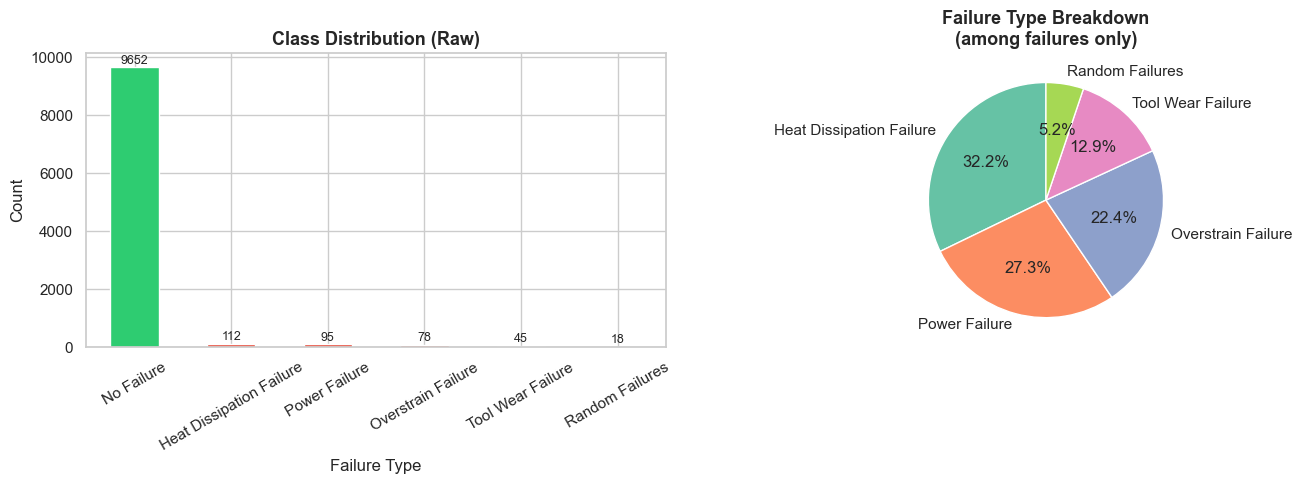


Imbalance ratio - No Failure : Failures = 9652 : 348


In [35]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

counts = df['Failure Type'].value_counts()
colors = ['#2ecc71' if c == 'No Failure' else '#e74c3c' for c in counts.index]
counts.plot(kind='bar', ax=axes[0], color=colors, edgecolor='white')
axes[0].set_title('Class Distribution (Raw)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Failure Type')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=30)
for bar, count in zip(axes[0].patches, counts):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
                 f'{count}', ha='center', va='bottom', fontsize=9)

failure_counts = df[df['Failure Type'] != 'No Failure']['Failure Type'].value_counts()
axes[1].pie(failure_counts, labels=failure_counts.index, autopct='%1.1f%%',
            startangle=90, colors=sns.color_palette('Set2', len(failure_counts)))
axes[1].set_title('Failure Type Breakdown\n(among failures only)', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=120, bbox_inches='tight')
plt.show()
print(f'\nImbalance ratio - No Failure : Failures = {counts["No Failure"]} : {counts[counts.index != "No Failure"].sum()}')

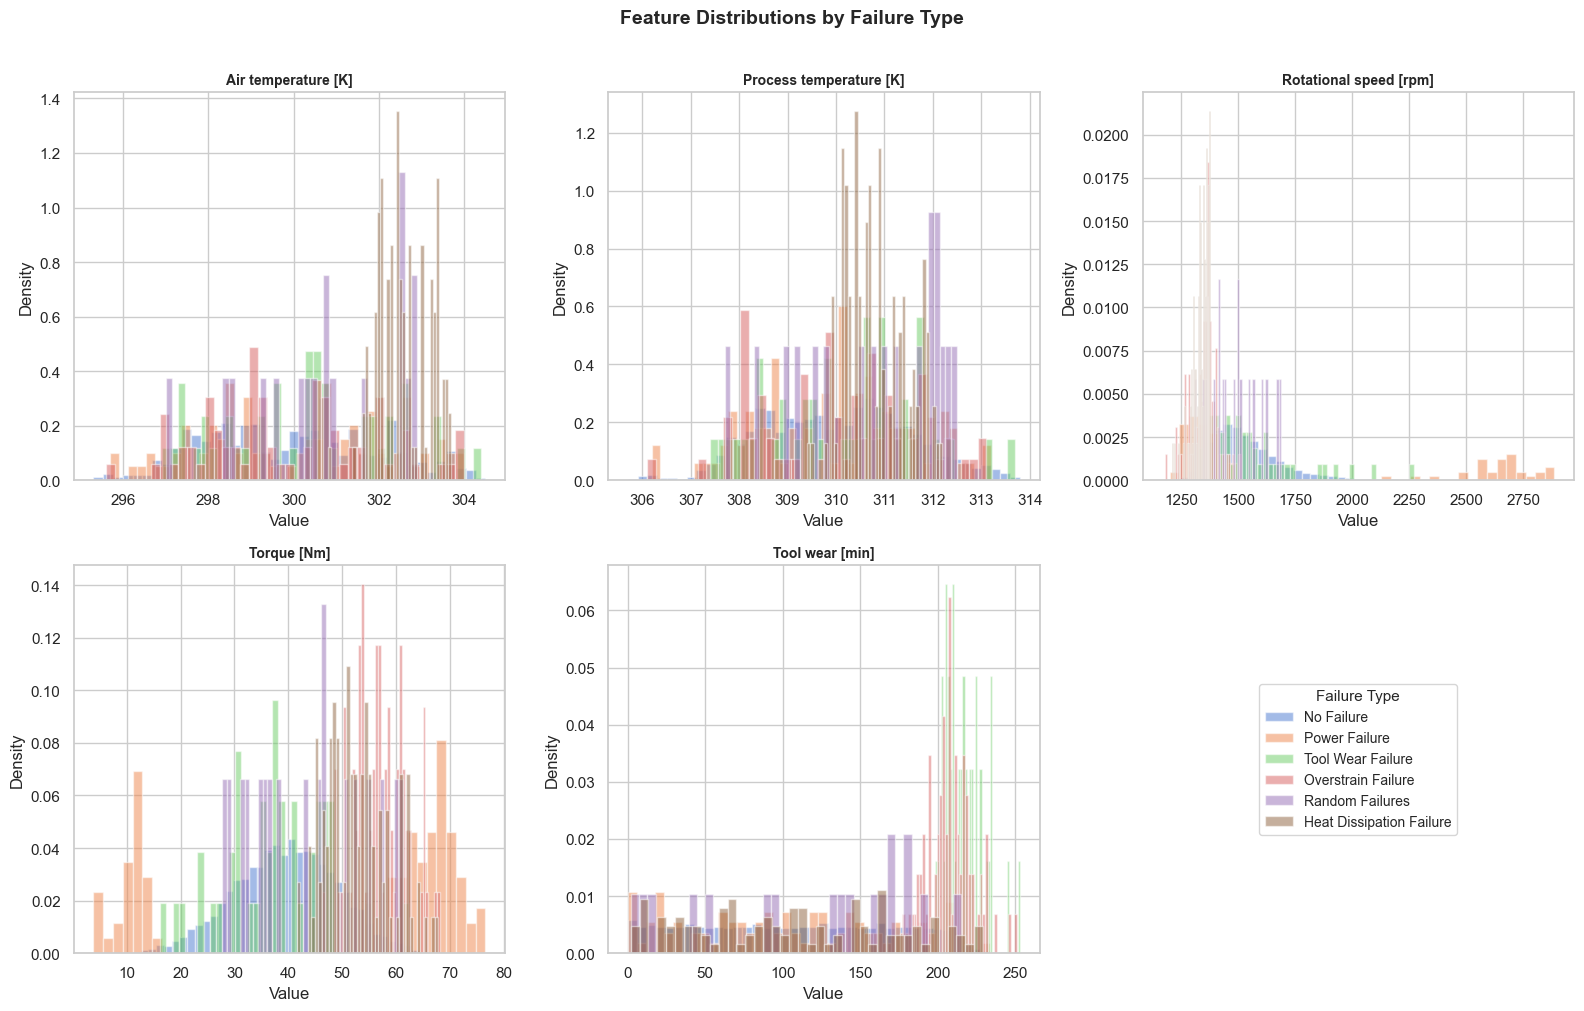

In [36]:
num_features = ['Air temperature [K]', 'Process temperature [K]',
                'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, feat in enumerate(num_features):
    for ftype in df['Failure Type'].unique():
        subset = df[df['Failure Type'] == ftype][feat]
        axes[i].hist(subset, bins=40, alpha=0.5, label=ftype, density=True)
    axes[i].set_title(feat, fontsize=10, fontweight='bold')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Density')

axes[5].axis('off')
handles, labels = axes[0].get_legend_handles_labels()
axes[5].legend(handles, labels, loc='center', fontsize=10, title='Failure Type', title_fontsize=11)

plt.suptitle('Feature Distributions by Failure Type', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=120, bbox_inches='tight')
plt.show()

In [37]:
def engineer_features(df):
    df = df.copy()

    df['temp_diff'] = df['Process temperature [K]'] - df['Air temperature [K]']

    df['power_W'] = df['Torque [Nm]'] * (df['Rotational speed [rpm]'] * 2 * np.pi / 60)

    df['torque_x_wear'] = df['Torque [Nm]'] * df['Tool wear [min]']

    df['rpm_per_torque'] = df['Rotational speed [rpm]'] / (df['Torque [Nm]'] + 1e-6)

    type_map = {'L': 0, 'M': 1, 'H': 2}
    df['type_encoded'] = df['Type'].map(type_map)

    return df

df = engineer_features(df)
print('New features added:')
print(['temp_diff', 'power_W', 'torque_x_wear', 'rpm_per_torque', 'type_encoded'])
df[['temp_diff', 'power_W', 'torque_x_wear', 'rpm_per_torque', 'type_encoded']].describe()

New features added:
['temp_diff', 'power_W', 'torque_x_wear', 'rpm_per_torque', 'type_encoded']


,temp_diff,power_W,torque_x_wear,rpm_per_torque,type_encoded
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,10.000630,6279.744953,4314.664550,43.167215,0.500300
std,1.001094,1067.418295,2826.567692,25.053905,0.671301
min,7.600000,1148.440610,0.000000,15.665796,0.000000
25%,9.300000,5561.184484,1963.650000,30.482987,0.000000
50%,9.800000,6271.027344,4012.950000,37.403703,0.000000
75%,11.000000,7003.002724,6279.000000,48.449456,1.000000
max,12.100000,10469.923005,16497.000000,759.473484,2.000000


In [38]:
FEATURE_COLS = [
    'Air temperature [K]',
    'Process temperature [K]',
    'Rotational speed [rpm]',
    'Torque [Nm]',
    'Tool wear [min]',
    'type_encoded',
    'temp_diff',
    'power_W',
    'torque_x_wear',
    'rpm_per_torque'
]

TARGET_COL = 'Failure Type'

X = df[FEATURE_COLS].copy()

le = LabelEncoder()
y = le.fit_transform(df[TARGET_COL])

class_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print('Class encoding:')
for k, v in sorted(class_mapping.items(), key=lambda x: x[1]):
    print(f'  {v}: {k}')

print(f'\nX shape: {X.shape}')
print(f'y distribution: {dict(zip(*np.unique(y, return_counts=True)))}')

Class encoding:
  0: Heat Dissipation Failure
  1: No Failure
  2: Overstrain Failure
  3: Power Failure
  4: Random Failures
  5: Tool Wear Failure

X shape: (10000, 10)
y distribution: {0: 112, 1: 9652, 2: 78, 3: 95, 4: 18, 5: 45}


In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print(f'Train size: {X_train.shape[0]:,} | Test size: {X_test.shape[0]:,}')
print(f'\nTrain class distribution:')
train_counts = pd.Series(y_train).value_counts().sort_index()
for idx, cnt in train_counts.items():
    print(f'  [{idx}] {le.classes_[idx]}: {cnt}')

Train size: 8,000 | Test size: 2,000

Train class distribution:
  [0] Heat Dissipation Failure: 90
  [1] No Failure: 7722
  [2] Overstrain Failure: 62
  [3] Power Failure: 76
  [4] Random Failures: 14
  [5] Tool Wear Failure: 36


Before SMOTE: {0: 90, 1: 7722, 2: 62, 3: 76, 4: 14, 5: 36}
After  SMOTE: {0: 7722, 1: 7722, 2: 7722, 3: 7722, 4: 7722, 5: 7722}

Training samples: 8,000 → 46,332


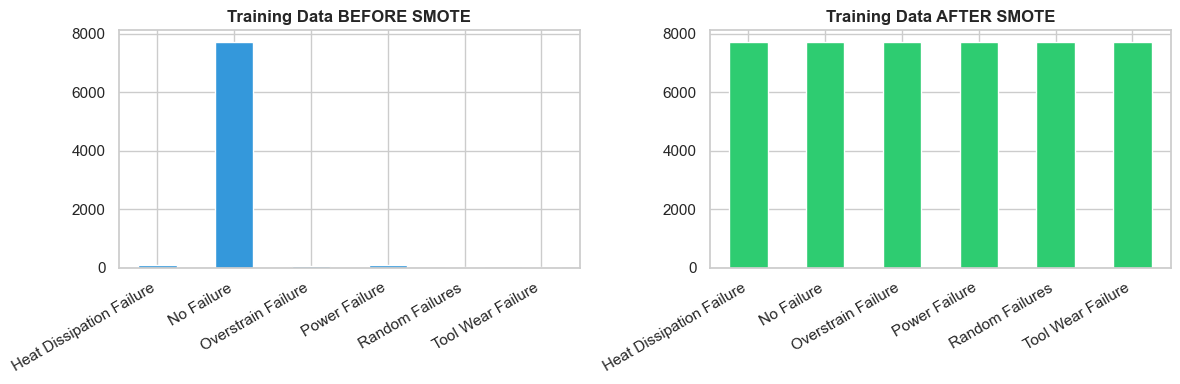

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(
    sampling_strategy='not majority',
    k_neighbors=3,
    random_state=RANDOM_STATE
)

X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

print('Before SMOTE:', dict(zip(*np.unique(y_train, return_counts=True))))
print('After  SMOTE:', dict(zip(*np.unique(y_train_res, return_counts=True))))
print(f'\nTraining samples: {len(y_train):,} → {len(y_train_res):,}')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
before = pd.Series(y_train).value_counts().sort_index()
after = pd.Series(y_train_res).value_counts().sort_index()
class_names = [le.classes_[i] for i in before.index]

before.plot(kind='bar', ax=axes[0], color='#3498db', edgecolor='white')
axes[0].set_title('Training Data BEFORE SMOTE', fontweight='bold')
axes[0].set_xticklabels(class_names, rotation=30, ha='right')

after.plot(kind='bar', ax=axes[1], color='#2ecc71', edgecolor='white')
axes[1].set_title('Training Data AFTER SMOTE', fontweight='bold')
axes[1].set_xticklabels(class_names, rotation=30, ha='right')

plt.tight_layout()
plt.savefig('smote_distribution.png', dpi=120, bbox_inches='tight')
plt.show()

In [41]:
classes = np.unique(y_train_res)
weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train_res
)
class_weight_dict = dict(zip(classes, weights))
print('Class weights:')
for cls, w in class_weight_dict.items():
    print(f'  [{cls}] {le.classes_[cls]}: {w:.4f}')

Class weights:
  [0] Heat Dissipation Failure: 1.0000
  [1] No Failure: 1.0000
  [2] Overstrain Failure: 1.0000
  [3] Power Failure: 1.0000
  [4] Random Failures: 1.0000
  [5] Tool Wear Failure: 1.0000


In [43]:
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight=class_weight_dict,
    n_jobs=-1,
    random_state=RANDOM_STATE
)
rf_model.fit(X_train_res, y_train_res)

sample_weights = np.array([class_weight_dict[y] for y in y_train_res])

xgb_model = xgb.XGBClassifier(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    num_class=len(le.classes_),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
xgb_model.fit(
    X_train_res, y_train_res,
    sample_weight=sample_weights,
    eval_set=[(X_test_scaled, y_test)],
    verbose=50
)

[0]	validation_0-mlogloss:1.70307
[50]	validation_0-mlogloss:0.43494
[100]	validation_0-mlogloss:0.20617
[150]	validation_0-mlogloss:0.12862
[200]	validation_0-mlogloss:0.10010
[250]	validation_0-mlogloss:0.09073
[300]	validation_0-mlogloss:0.08697
[350]	validation_0-mlogloss:0.08560
[399]	validation_0-mlogloss:0.08510


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=400,
              n_jobs=-1, num_class=6, num_parallel_tree=None, ...)

  Random Forest — Evaluation Results
Accuracy:         0.9790
Macro F1:         0.6526
Weighted F1:      0.9825

Per-class report:
                          precision    recall  f1-score   support

Heat Dissipation Failure      0.917     1.000     0.957        22
              No Failure      0.994     0.985     0.989      1930
      Overstrain Failure      0.941     1.000     0.970        16
           Power Failure      1.000     1.000     1.000        19
         Random Failures      0.000     0.000     0.000         4
       Tool Wear Failure      0.000     0.000     0.000         9

                accuracy                          0.979      2000
               macro avg      0.642     0.664     0.653      2000
            weighted avg      0.986     0.979     0.982      2000



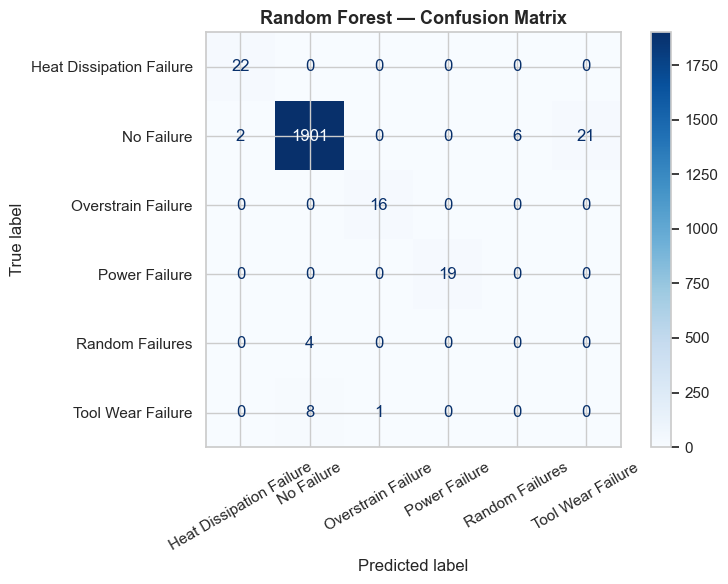

  XGBoost — Evaluation Results
Accuracy:         0.9805
Macro F1:         0.6451
Weighted F1:      0.9828

Per-class report:
                          precision    recall  f1-score   support

Heat Dissipation Failure      0.880     1.000     0.936        22
              No Failure      0.994     0.987     0.990      1930
      Overstrain Failure      0.941     1.000     0.970        16
           Power Failure      0.950     1.000     0.974        19
         Random Failures      0.000     0.000     0.000         4
       Tool Wear Failure      0.000     0.000     0.000         9

                accuracy                          0.981      2000
               macro avg      0.627     0.664     0.645      2000
            weighted avg      0.985     0.981     0.983      2000



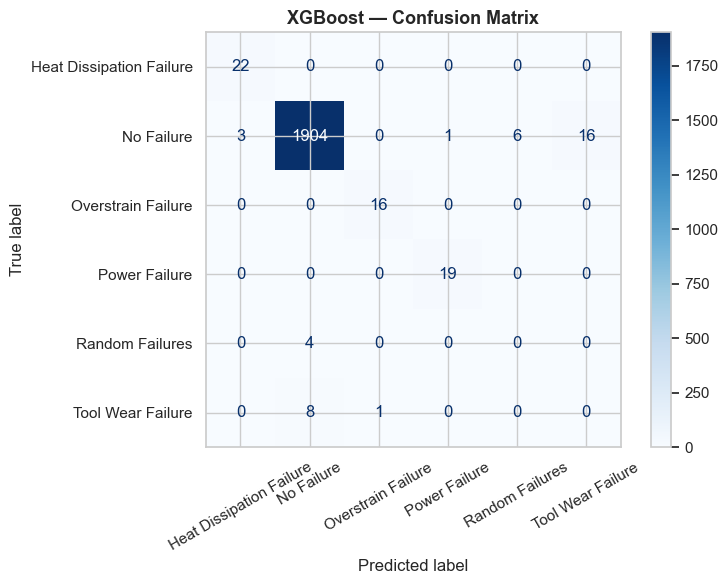

In [44]:
def evaluate_model(model, X_test, y_test, model_name, label_encoder):
    y_pred = model.predict(X_test)

    print(f'  {model_name} — Evaluation Results')

    acc = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    weighted_f1 = f1_score(y_test, y_pred, average='weighted')

    print(f'Accuracy:         {acc:.4f}')
    print(f'Macro F1:         {macro_f1:.4f}')
    print(f'Weighted F1:      {weighted_f1:.4f}')

    print(f'\nPer-class report:')
    print(classification_report(
        y_test, y_pred,
        target_names=label_encoder.classes_,
        digits=3
    ))

    fig, ax = plt.subplots(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=label_encoder.classes_
    )
    disp.plot(ax=ax, colorbar=True, cmap='Blues', xticks_rotation=30)
    ax.set_title(f'{model_name} — Confusion Matrix', fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{model_name.replace(" ", "_")}.png',
                dpi=120, bbox_inches='tight')
    plt.show()

    return {'accuracy': acc, 'macro_f1': macro_f1, 'weighted_f1': weighted_f1}

rf_metrics = evaluate_model(rf_model, X_test_scaled, y_test, 'Random Forest', le)
xgb_metrics = evaluate_model(xgb_model, X_test_scaled, y_test, 'XGBoost', le)

               accuracy  macro_f1  weighted_f1
Random Forest    0.9790    0.6526       0.9825
XGBoost          0.9805    0.6451       0.9828


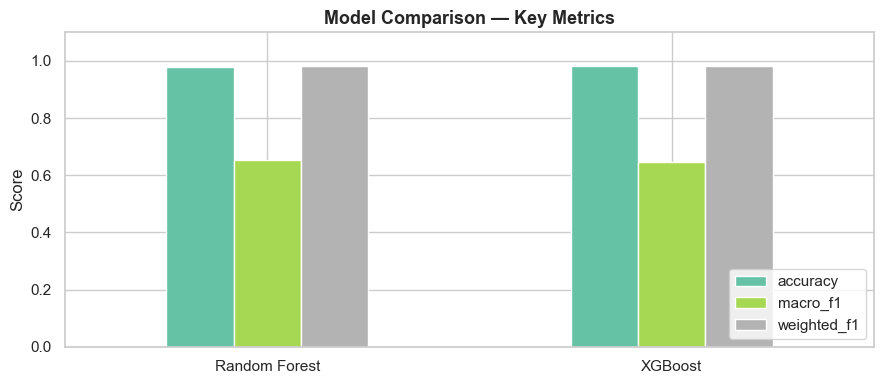


Best model: Random Forest (Macro F1 = 0.6526)


In [46]:
metrics_df = pd.DataFrame({
    'Random Forest': rf_metrics,
    'XGBoost': xgb_metrics
}).T

print(metrics_df.round(4).to_string())

metrics_df.plot(kind='bar', figsize=(9, 4), colormap='Set2', edgecolor='white')
plt.title('Model Comparison — Key Metrics', fontsize=13, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.ylim(0, 1.1)
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=120, bbox_inches='tight')
plt.show()

best_model_name = 'XGBoost' if xgb_metrics['macro_f1'] >= rf_metrics['macro_f1'] else 'Random Forest'
best_model = xgb_model if best_model_name == 'XGBoost' else rf_model
print(f'\nBest model: {best_model_name} (Macro F1 = {max(xgb_metrics["macro_f1"], rf_metrics["macro_f1"]):.4f})')

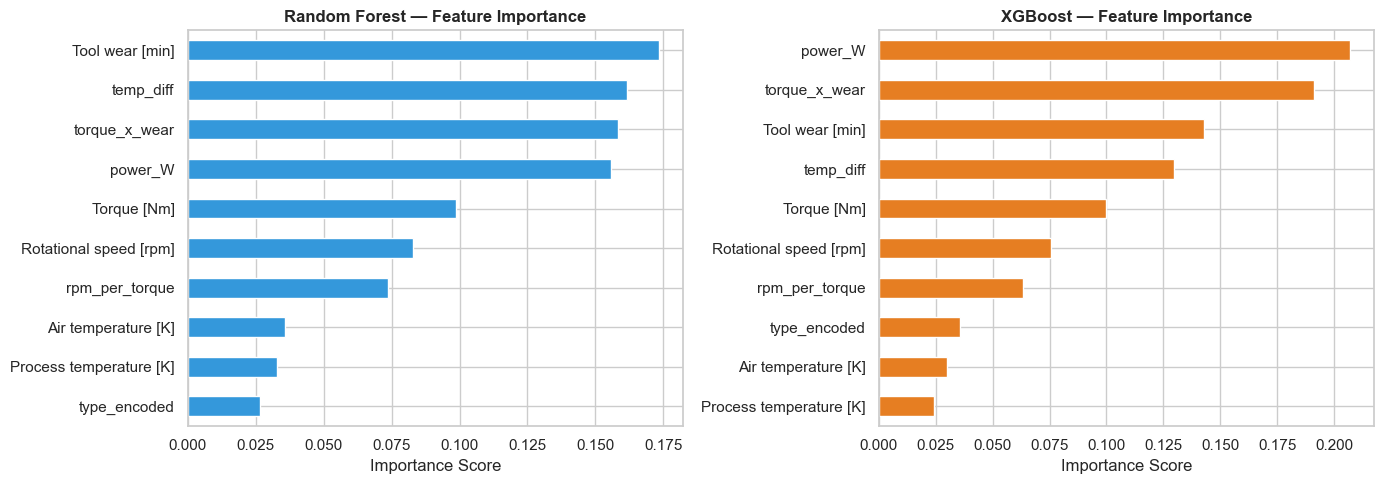

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

rf_importance = pd.Series(rf_model.feature_importances_, index=FEATURE_COLS).sort_values(ascending=True)
rf_importance.plot(kind='barh', ax=axes[0], color='#3498db', edgecolor='white')
axes[0].set_title('Random Forest — Feature Importance', fontweight='bold')
axes[0].set_xlabel('Importance Score')

xgb_importance = pd.Series(xgb_model.feature_importances_, index=FEATURE_COLS).sort_values(ascending=True)
xgb_importance.plot(kind='barh', ax=axes[1], color='#e67e22', edgecolor='white')
axes[1].set_title('XGBoost — Feature Importance', fontweight='bold')
axes[1].set_xlabel('Importance Score')

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=120, bbox_inches='tight')
plt.show()

In [48]:
import os
os.makedirs('model_artifacts', exist_ok=True)

joblib.dump(best_model, 'model_artifacts/model.pkl')
joblib.dump(rf_model, 'model_artifacts/random_forest.pkl')
joblib.dump(xgb_model, 'model_artifacts/xgboost.pkl')
joblib.dump(scaler, 'model_artifacts/scaler.pkl')
joblib.dump(le, 'model_artifacts/label_encoder.pkl')

import json
metadata = {
    'feature_cols': FEATURE_COLS,
    'target_col': TARGET_COL,
    'classes': le.classes_.tolist(),
    'class_mapping': {int(v): k for k, v in class_mapping.items()},
    'best_model': best_model_name,
    'model_metrics': {
        'Random Forest': {k: round(v, 4) for k, v in rf_metrics.items()},
        'XGBoost': {k: round(v, 4) for k, v in xgb_metrics.items()}
    }
}

with open('model_artifacts/metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)